In [6]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os
#%run helpers_preproc.ipynb
%run helpers_preproc.ipynb
%matplotlib widget

# Hyper Parameters

In [7]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_presentation/'
K = 5
radiuss = [0.0002,0.0004,0.1]
train_size = 450 * len(radiuss)
test_size = (600-450) * len(radiuss)

# 1. expand dataset and scramble

In [8]:
expand(origDataDir, newDataDir, radiuss)
scramble(newDataDir, 10000,600 * len(radiuss))

# 2. read in the dataset

## 2.1 read in v (252 x 3),f (...x...) and cluster

In [9]:
ver_list = []
adj_list = []
Nadj_list = []
gMat_list = []

for i in range(600 * len(radiuss)):
    v, f = get_nodes(newDataDir + 'T' + str(i) + '.obj')
    group_mat = K_mean_cluster(v, K)
    
    adj = get_adj_from_f(f)            
    normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])
    ver_list.append(v)
    adj_list.append(adj)
    Nadj_list.append(normed_adj)
    gMat_list.append(group_mat)
    
    
vers = np.array(ver_list)
adjs = np.array(adj_list)
Nadjs = np.array(Nadj_list)
gMats = np.array(gMat_list)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_10125/3324085628.py:11: RuntimeWarning: invalid value encountered in divide
  normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])
/Users/richardwang/.conda/envs/TSM/lib/python3.10/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


## 2.2 Read in the labels

In [10]:
label_np = np.array(readLbl(600 * len(radiuss),newDataDir+'labels.txt'))
label_np_train = label_np[:train_size]
label_np_test = label_np[train_size:]

## 2.3 Split into training set and testing set

In [11]:
vers_train = torch.tensor(vers[:train_size]).float()
adjs_train = torch.tensor(adjs[:train_size]).float()
nadjs_train = torch.nan_to_num(torch.tensor(Nadjs[:train_size]).float(),0,0,0)
gMats_train = torch.tensor(gMats[:train_size]).float()
label_train = torch.tensor(label_np_train).float()

vers_test = torch.tensor(vers[train_size:]).float()
adjs_test = torch.tensor(adjs[train_size:]).float()
nadjs_test = torch.nan_to_num(torch.tensor(Nadjs[train_size:]).float(),0,0,0)
gMats_test = torch.tensor(gMats[:train_size]).float()
label_test = torch.tensor(label_np_test).float()

label_mat_train = torch.tensor(np.where(igl.all_pairs_distances(label_np_train,label_np_train,False) > 0.5,0,1)).float()
label_mat_test = torch.tensor(np.where(igl.all_pairs_distances(label_np_test,label_np_test,False) > 0.5,0,1)).float()

In [43]:
#detect_nan(label_mat_train)

In [44]:
#label_mat_train

In [45]:
#print message about training and testing dataset
# print(vers_train.shape)
# print(adjs_train.shape)
# print(nadjs_train.shape)
# print(gMats_train.shape)

# 3. Training

## 3.1 Hyperparameters for training

In [12]:
contraGWs = [5,5,5,5]
contraMWs = [5,5,5,5]
atkGWs = [5,5,5,5]
atkMWs = [5,5,5,K * 3]

## 3.2 Initialize neural networks

In [13]:
%run NNs.ipynb
%run helpers_preproc.ipynb
contraG = GCN(3,contraGWs)
contraM = MLP(252* contraGWs[len(contraGWs)-1],contraMWs)
atkG = GCN(3,atkGWs)
atkM = MLP(252* atkGWs[len(contraGWs)-1],atkMWs)

## 3.4 Extract node-level features from clean data

In [14]:
feas_clean = extract_node_feature(vers_train,adjs_train)

In [15]:
%run L.ipynb

## 3.5 Feed clean data into contraNN🤠

## 3.6 Train atkNN😈 with contraNN🤠

In [16]:
atkLR = 0.0001
contraLR = 0.0001

In [ ]:
for contraI in range(100):
    optAtk = optim.Adam(atkG.weights + atkM.weights,lr = atkLR)
    print("\t loss \t\t same mean \t diff mean \t same std")

    for atkI in range(10):
        optAtk.zero_grad()

        atkOutFlat = atkM.forward(atkG.forward(nadjs_train,feas_clean))
        atkOut = torch.reshape(atkOutFlat,[train_size,K,3])
        poisonedVers = translate_by_group(vers_train,gMats_train,atkOut)

        feas_poisoned = extract_node_feature(poisonedVers,adjs_train)

        contraOutPoisoned = contraM.forward(contraG.forward(nadjs_train,feas_poisoned))
        contraLossPoisoned = lossAtkF(contraOutPoisoned,label_mat_train)

        contraLossPoisoned.backward()
        optAtk.step()
        
    optContra = optim.Adam(contraG.weights + contraM.weights,lr = contraLR)
    print("\t loss \t\t same mean \t diff mean \t same std")
        
    for contraI in range(10):
        optContra.zero_grad()
        
        atkOutFlat1 = atkM.forward(atkG.forward(nadjs_train,feas_clean))
        atkOut1 = torch.reshape(atkOutFlat1,[train_size,K,3])
        poisonedVers1 = translate_by_group(vers_train,gMats_train,atkOut1)
        
        feas_poisoned1 = extract_node_feature(poisonedVers1,adjs_train)
        
        contraOutPoisoned1 = contraM.forward(contraG.forward(nadjs_train,feas_poisoned1))
        contraLossPoisoned1 = lossContraF(contraOutPoisoned1,label_mat_train)
    
        contraLossPoisoned1.backward()
        optContra.step()

	 loss 		 same mean 	 diff mean 	 same std
A:😈 	 -0.00011 	 0.07975 	 0.08423 	 0.43603
A:😈 	 -7e-05 	 0.07995 	 0.08439 	 0.43711
A:😈 	 -2e-05 	 0.08015 	 0.08455 	 0.43818
A:😈 	 2e-05 	 0.08031 	 0.08468 	 0.43907
A:😈 	 7e-05 	 0.08043 	 0.08476 	 0.43972
A:😈 	 0.00011 	 0.08053 	 0.08482 	 0.44027
A:😈 	 0.00015 	 0.08063 	 0.08489 	 0.44083
A:😈 	 0.00019 	 0.08075 	 0.08498 	 0.44151
A:😈 	 0.00022 	 0.08091 	 0.08511 	 0.44236
A:😈 	 0.00026 	 0.08109 	 0.08527 	 0.44336
	 loss 		 same mean 	 diff mean 	 same std
C:🤠 	 0.00029 	 0.08129 	 0.08544 	 0.44444
C:🤠 	 0.00026 	 0.0809 	 0.08507 	 0.44233
C:🤠 	 0.00022 	 0.08051 	 0.08469 	 0.44021
C:🤠 	 0.00019 	 0.08011 	 0.08431 	 0.43805
C:🤠 	 0.00015 	 0.07971 	 0.08392 	 0.43587
C:🤠 	 0.00012 	 0.07931 	 0.08353 	 0.43369
C:🤠 	 8e-05 	 0.07891 	 0.08315 	 0.43153
C:🤠 	 5e-05 	 0.07853 	 0.08277 	 0.42943
C:🤠 	 1e-05 	 0.07816 	 0.08242 	 0.42741
C:🤠 	 -2e-05 	 0.0778 	 0.08208 	 0.42549
	 loss 		 same mean 	 diff mean 	 same std
A:😈 	

A:😈 	 -0.00061 	 0.04436 	 0.0474 	 0.243
A:😈 	 -0.00059 	 0.0437 	 0.04668 	 0.23933
A:😈 	 -0.00058 	 0.04306 	 0.046 	 0.23587
	 loss 		 same mean 	 diff mean 	 same std
C:🤠 	 -0.00057 	 0.04255 	 0.04545 	 0.23305
C:🤠 	 -0.00059 	 0.04285 	 0.04578 	 0.2347
C:🤠 	 -0.0006 	 0.04316 	 0.04613 	 0.2364
C:🤠 	 -0.00062 	 0.04348 	 0.04648 	 0.23813


## 3.5 feed features into contraNN

In [151]:
cG_out = contraG(adjs_train, feas)
cM_out = contraM(cG_out)
aG_out = atkG(adjs_train,feas)
aM_out = atkM(aG_out)
aM_out_reshaped = torch.reshape(aM_out, [train_size,K,3])

## 3.3 Modify coordinates by group

In [152]:
transformations = translate_by_group(vers_train,gMats_train,aM_out_reshaped)

In [153]:
poisoned_data = vers_train + transformations

## 3.6 Calculate contraNN Loss

## 3.7 backward

Adversarial Training Loop
contraN
atkN



for ............:
    disSimMat = contraN(training data)
    
    
    for .............:
        poisonedData = atkN(training Data)
        lossAtk(poisonedData, contraN)
        backward(atkN)
    
    LossContra(atkN(training Data) = poisoned Data)
    backward()

In [ ]:
# optAtk = optim.Adam(atkG.weights + atkG.weights,lr = 0.01)

# print("loss, same mean, diff mean, std")

# for atkI in range(10):
#     optAtk.zero_grad()
    
#     atkOutFlat = atkM.forward(atkG.forward(nadjs_train,feas_clean))
#     atkOut = torch.reshape(atkOutFlat,[train_size,K,3])
#     poisonedVers = translate_by_group(vers_train,gMats_train,atkOut)
    
#     feas_poisoned = extract_node_feature(poisonedVers,adjs_train)
    
#     contraOutPoisoned = contraM.forward(contraG.forward(nadjs_train,feas_poisoned))
#     contraLossPoisoned = lossContraF(contraOutPoisoned,label_mat_train)
    
#     contraLossPoisoned.backward()
#     optAtk.step()
#     #lossContraF(output,label_mat_train)

## Thank you

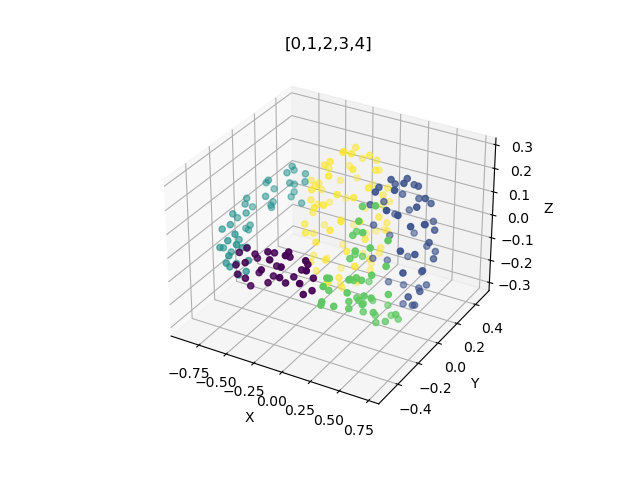

In [37]:
from mpl_toolkits.mplot3d import axes3d

dataPlot = vs_train[100]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(dataPlot[:,0], dataPlot[:,1], dataPlot[:,2], label=dataPlot[:,3], c = dataPlot[:,3], cmap = 'viridis')
#ax.axis('off')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('[0,1,2,3,4]')

#plt.legend(loc="upper right")

plt.show()